In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('data/Flight_delay.csv')

In [4]:
df.head()

,DayOfWeek,Date,DepTime,ArrTime,CRSArrTime,UniqueCarrier,Airline,FlightNum,TailNum,ActualElapsedTime,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,4,03-01-2019,1829,1959,1925,WN,Southwest Airlines Co.,3920,N464WN,90,...,3,10,0,N,0,2,0,0,0,32
1,4,03-01-2019,1937,2037,1940,WN,Southwest Airlines Co.,509,N763SW,240,...,3,7,0,N,0,10,0,0,0,47
2,4,03-01-2019,1644,1845,1725,WN,Southwest Airlines Co.,1333,N334SW,121,...,6,8,0,N,0,8,0,0,0,72
3,4,03-01-2019,1452,1640,1625,WN,Southwest Airlines Co.,675,N286WN,228,...,7,8,0,N,0,3,0,0,0,12
4,4,03-01-2019,1323,1526,1510,WN,Southwest Airlines Co.,4,N674AA,123,...,4,9,0,N,0,0,0,0,0,16


In [5]:
df = df[['DayOfWeek','Date','DepTime','Airline','Origin','Dest','CarrierDelay']]
df

,DayOfWeek,Date,DepTime,Airline,Origin,Dest,CarrierDelay
0,4,03-01-2019,1829,Southwest Airlines Co.,IND,BWI,2
1,4,03-01-2019,1937,Southwest Airlines Co.,IND,LAS,10
2,4,03-01-2019,1644,Southwest Airlines Co.,IND,MCO,8
3,4,03-01-2019,1452,Southwest Airlines Co.,IND,PHX,3
4,4,03-01-2019,1323,Southwest Airlines Co.,IND,TPA,0
...,...,...,...,...,...,...,...
484546,5,13-06-2019,1609,American Airlines Inc.,DFW,MCO,27
484547,6,14-06-2019,1616,American Airlines Inc.,DFW,MCO,11
484548,2,17-06-2019,1617,American Airlines Inc.,DFW,MCO,0
484549,7,22-06-2019,1607,American Airlines Inc.,DFW,MCO,1


In [6]:
df.isnull().sum()


DayOfWeek       0
Date            0
DepTime         0
Airline         0
Origin          0
Dest            0
CarrierDelay    0
dtype: int64

In [7]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

In [8]:
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day

In [9]:
# Drop the original 'Date' column since XGBoost doesn't handle datetime types
df = df.drop(columns=['Date'])


In [10]:
categories = df.select_dtypes(include=['object']).columns
categories

Index(['Airline', 'Origin', 'Dest'], dtype='object')

In [12]:
df_encoded = pd.get_dummies(df, drop_first=True)

In [13]:
df_encoded['is_delayed_60+'] = np.where(df_encoded['CarrierDelay'] > 60, 1, 0)
# df_encoded['is_delayed_15+'] = np.where(df_encoded['CarrierDelay'] > 30, 1, 0)

In [14]:
X = df_encoded.drop(columns=['is_delayed_60+', 'CarrierDelay'])
y = df_encoded['is_delayed_60+']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [16]:
train_set = pd.concat([X_train, y_train], axis= 1)

In [17]:
categories

Index(['Airline', 'Origin', 'Dest'], dtype='object')

In [18]:
# Reversing one-hot encoding for multiple sets of categorical variables
for category in categories:
    one_hot_columns = [col for col in train_set.columns if col.startswith(f'{category}_')]
    train_set[category] = train_set[one_hot_columns].idxmax(axis=1)
    train_set = train_set.drop(columns=one_hot_columns)
    train_set[category] = train_set[category].str.replace(f'{category}_', '')

In [19]:
train_set

,DayOfWeek,DepTime,month,day,is_delayed_60+,Airline,Origin,Dest
132504,5,2124,2,22,0,US Airways Inc.,PHX,LAS
483050,4,2218,6,19,0,American Airlines Inc.,DFW,OAK
318401,6,1500,4,26,1,American Airlines Inc.,ORD,MIA
259287,3,2112,3,12,1,American Airlines Inc.,JNU,SEA
77835,6,1730,1,26,0,American Airlines Inc.,SJU,ORD
...,...,...,...,...,...,...,...,...
439107,4,1707,6,19,0,United Air Lines Inc.,PIT,ORD
117952,3,1752,2,27,0,Skywest Airlines Inc.,ORD,LAN
435829,2,1826,6,24,0,United Air Lines Inc.,LAX,ORD
305711,1,1350,4,21,0,Atlantic Southeast Airlines,SAT,ATL


In [20]:
train_set['is_delayed_60+'].value_counts()


is_delayed_60+
0    313876
1     25309
Name: count, dtype: int64

In [21]:
train_set['is_delayed_60+'].mean()

np.float64(0.07461709686454294)

In [22]:
train_set.groupby('Airline')['is_delayed_60+'].mean().sort_values(ascending=False).round(3)*100

Airline
Atlantic Southeast Airlines     16.3
Hawaiian Airlines Inc.          14.2
Skywest Airlines Inc.           10.3
American Airlines Inc.           9.0
Delta Air Lines Inc.             8.4
US Airways Inc.                  7.6
United Air Lines Inc.            7.5
American Eagle Airlines Inc.     7.0
JetBlue Airways                  5.9
Frontier Airlines Inc.           4.7
Southwest Airlines Co.           3.3
Name: is_delayed_60+, dtype: float64

In [23]:
DayOfWeek_pct_delayed = train_set.groupby('DayOfWeek')['is_delayed_60+'].mean().round(3)*100
DayOfWeek_pct_delayed

DayOfWeek
1    7.6
2    7.1
3    7.6
4    6.9
5    6.8
6    9.0
7    7.9
Name: is_delayed_60+, dtype: float64

In [24]:
pct_delay_by_origin = train_set.groupby('Origin')['is_delayed_60+'].mean().sort_values(ascending=False).round(3)*100
pct_delay_by_origin.head(20)

Origin
ACY    40.0
LWB    40.0
MQT    33.8
MCN    27.8
SLE    26.7
SCE    25.0
PFN    23.6
PHF    23.1
MKG    22.6
TRI    22.5
MEI    22.2
HHH    21.8
OAJ    21.5
FAY    21.4
ROW    21.4
VLD    20.3
AVL    19.8
ABI    19.4
EWN    19.3
CMI    18.4
Name: is_delayed_60+, dtype: float64

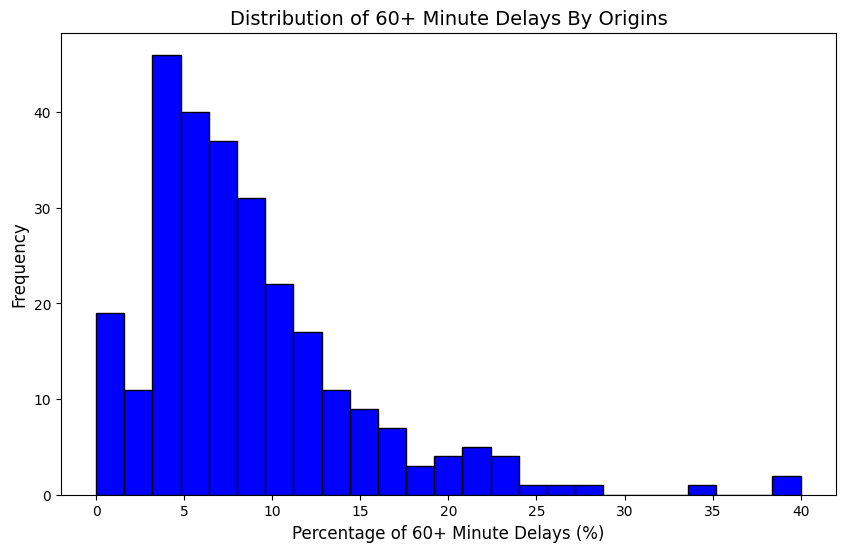

In [25]:
# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(pct_delay_by_origin.values, bins=25, color='blue', edgecolor='black')

# Add labels and title
plt.title("Distribution of 60+ Minute Delays By Origins", fontsize=14)
plt.xlabel("Percentage of 60+ Minute Delays (%)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Show the plot
plt.show()

In [26]:
xgb_model = xgb.XGBClassifier(random_state=0, eval_metric='logloss')

In [27]:
xgb_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [28]:
# Train the model
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [29]:
y_pred = xgb_model.predict(X_test)

In [30]:
print("XGBoost Classifier (Baseline):")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

XGBoost Classifier (Baseline):
Accuracy: 0.9248


In [32]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[134322,     61],
       [ 10871,    112]])

In [33]:
# Predict probabilities for the test set (to calculate AUC)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]  # We need probabilities for the positive class

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score:.4f}")

AUC Score: 0.7135


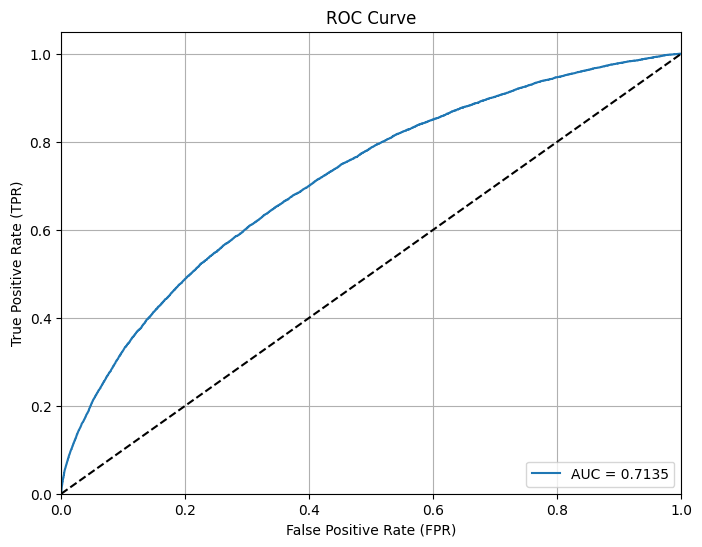

In [34]:
# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [36]:
# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 250],
    'subsample': [0.6,  1.0]
}

# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(random_state=0,
                              eval_metric='logloss')

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, 
                           param_grid=param_grid, 
                           cv=3, 
                           scoring='roc_auc', 
                           verbose=1, 
                           n_jobs=-1)

# Fit the grid search model
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.2], 'max_depth': [3, 5, 7],
                         'n_estimators': [100, 250], 'subsample': [0.6, 1.0]},
             scoring='roc_auc', verbose=1)

In [37]:
# Best parameters from GridSearch
print("Best parameters found: ", grid_search.best_params_)

# Predict with the best model
y_pred_best = grid_search.best_estimator_.predict(X_test)

# Evaluate the tuned XGBoost model
print("XGBoost Classifier (Tuned):")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")

Best parameters found:  {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 250, 'subsample': 1.0}
XGBoost Classifier (Tuned):
Accuracy: 0.9248


In [38]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
cm

array([[134284,     99],
       [ 10829,    154]])

In [39]:
# Predict probabilities for the test set (to calculate AUC)
y_pred_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]  # We need probabilities for the positive class

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score:.4f}")

AUC Score: 0.7207


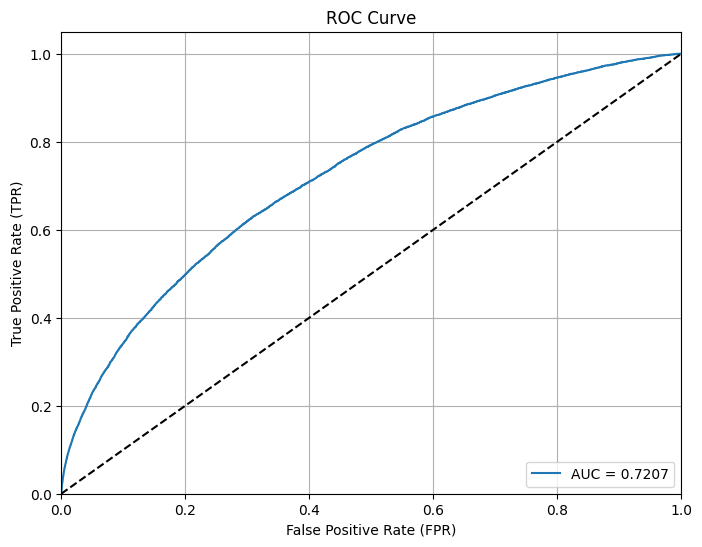

In [40]:
# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()